In [0]:
import platform
import io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
train_link="https://drive.google.com/open?id=1HGAP7Tk3twMCZ3OcqevhB_ZEY_PoobvP"
test_link="https://drive.google.com/open?id=1E9wa-HzI72LpS9YejEXsrbd5BPM5WU3T"
label_link="https://drive.google.com/open?id=15K5SMO_lrZLLqmkXouwI6mPGAhQNxM7-"

In [0]:
def getFile(link,pkl):
    fluff, id = link.split('=')
    downloaded = drive.CreateFile({'id':id})
    if pkl is True:
        downloaded.GetContentFile('file.pkl')
        file=pd.read_pickle('file.pkl')
        return file
    else:
        downloaded.GetContentFile('label.csv')
        file=pd.read_csv('label.csv')
        return file

In [0]:
train_images=getFile(train_link,True)
train_label=getFile(label_link,False)
test_images=getFile(test_link,True)

In [0]:
class DatasetMNIST(Dataset):
    
    def __init__(self, x, y, transform=None):
        self.transform = transform
        self.data=x
        self.labels=y
        self.train=True
        if y is None:
            self.labels=pd.DataFrame(np.zeros([len(x),2]))
            self.train=False
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index]
        label=-1
        if self.train is True:
            label = self.labels.iloc[index.item(),1]
        
        if self.transform is not None:
            image = torch.from_numpy(image)
            
        return image, label

In [0]:
transform=transforms.ToTensor()
train_image=DatasetMNIST(train_images,train_label,transform)
train_size = int(0.8 * len(train_image))
train,valid=torch.utils.data.dataset.random_split(train_image,[train_size,len(train_image)-train_size])
test_image=DatasetMNIST(test_images,None,transform)

In [0]:
BATCH_SIZE=100

train_loader=torch.utils.data.DataLoader(train,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid,batch_size=BATCH_SIZE,shuffle=False)
test_loader=torch.utils.data.DataLoader(test_image,batch_size=BATCH_SIZE,shuffle=False)

In [0]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
#         print(out.size())
        out = self.bn(out)
#         print(out.size())
        out = self.layer1(out)
#         print(out.size())
        out = self.layer2(out)
#         print(out.size())
        out = self.layer3(out)
#         print(out.size())
        out = self.avg_pool(out)
#         print(out.size())
        out = out.view(out.size(0), -1)
#         print(out.size())
        out = self.fc(out)
#         print("")
        return out

In [0]:
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
resnet = ResNet(**net_args)
use_gpu=torch.cuda.is_available()
print("GPU Available:{}".format(use_gpu))
if use_gpu:
    resnet.cuda()

GPU Available:True


In [0]:
criterion=nn.CrossEntropyLoss()

In [0]:
def trainResNet(epoch, model,train_loader,optimizer):
    model.train()

    total_loss=0;
    correct=0;

    for i, (image,label) in enumerate(train_loader):

        optimizer.zero_grad()

    #images=image.view(-1,28*28)

        image=image.unsqueeze_(0)
        image=image.permute(1, 0, 2,3)

        if use_gpu:
            image=image.cuda()
            label=label.cuda()

        prediction=model(image)

        loss=criterion(prediction,label)

        loss.backward()

        optimizer.step()

        total_loss+=loss
        pred_classes = prediction.data.max(1,keepdim=True)[1]
        correct += pred_classes.eq(label.data.view_as(pred_classes)).sum().double()

    mean_loss=total_loss/len(train_loader.dataset)
    acc=correct/len(train_loader.dataset)

    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))

    return mean_loss, acc

In [0]:
def evalResNet(model,eval_loader):
  
    model.eval()

    total_loss=0
    correct=0

    for i, (image,label) in enumerate(eval_loader):

        optimizer.zero_grad()

    #images=image.view(-1,28*28)

        image=image.unsqueeze_(0)
        image=image.permute(1, 0, 2,3)

        if use_gpu:
            image=image.cuda()
            label=label.cuda()

        prediction=model(image)

        loss=criterion(prediction,label)

        loss.backward()

        optimizer.step()

        total_loss+=loss

        pred_classes=prediction.data.max(1,keepdim=True)[1]

        correct+=pred_classes.eq(label.data.view_as(pred_classes)).sum().double()

    mean_loss=total_loss/len(eval_loader.dataset)
    acc=correct/len(eval_loader.dataset)

    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. *acc)) 

    return mean_loss, acc

In [0]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'cnn_{}.pt'.format(epoch)
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

In [0]:
optimizer=optim.Adam(resnet.parameters(),lr=0.0001)
# Number of epochs 
numEpochs = 100

# checkpoint frequency 
checkpoint_freq = 10

# path to save the data 
path = './'

# empty lists 
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

# traininng 
for epoch in range(1, numEpochs + 1):
    
    # train() function (see above)
    train_loss, train_acc = trainResNet(epoch, resnet, train_loader, optimizer)
    
    # eval() functionn (see above)
    test_loss, test_acc = evalResNet(resnet, valid_loader)    
    
    # append lists for plotting and printing 
    train_losses.append(train_loss)    
    test_losses.append(test_loss)
    
    train_accuracies.append(train_acc)    
    test_accuracies.append(test_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, resnet, path)

# Last checkpoint
save_model(numEpochs, resnet, path)
    
print("\n\n\nOptimization ended.\n") 

Train Epoch: 1   Avg_Loss: 0.02248   Acc: 5159.0/32000 (16.122%)
Eval:  Avg_Loss: 0.02164   Acc: 1593.0/8000 (19.913%)
Train Epoch: 2   Avg_Loss: 0.02023   Acc: 9256.0/32000 (28.925%)
Eval:  Avg_Loss: 0.01858   Acc: 2771.0/8000 (34.637%)
Train Epoch: 3   Avg_Loss: 0.01759   Acc: 13873.0/32000 (43.353%)
Eval:  Avg_Loss: 0.01590   Acc: 3669.0/8000 (45.862%)
Train Epoch: 4   Avg_Loss: 0.01514   Acc: 17839.0/32000 (55.747%)
Eval:  Avg_Loss: 0.01319   Acc: 4472.0/8000 (55.900%)
Train Epoch: 5   Avg_Loss: 0.01291   Acc: 20855.0/32000 (65.172%)
Eval:  Avg_Loss: 0.01104   Acc: 5186.0/8000 (64.825%)
Train Epoch: 6   Avg_Loss: 0.01097   Acc: 22927.0/32000 (71.647%)
Eval:  Avg_Loss: 0.00942   Acc: 5654.0/8000 (70.675%)
Train Epoch: 7   Avg_Loss: 0.00936   Acc: 24545.0/32000 (76.703%)
Eval:  Avg_Loss: 0.00816   Acc: 6004.0/8000 (75.050%)
Train Epoch: 8   Avg_Loss: 0.00805   Acc: 25608.0/32000 (80.025%)
Eval:  Avg_Loss: 0.00728   Acc: 6254.0/8000 (78.175%)
Train Epoch: 9   Avg_Loss: 0.00701   Acc: 

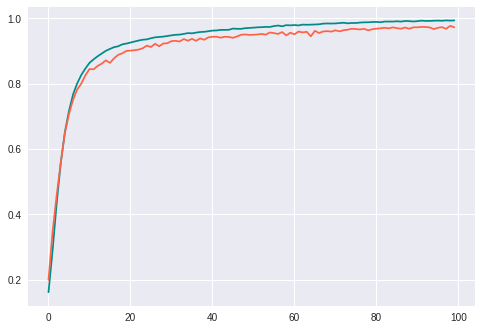

In [0]:
plt.plot(train_accuracies, color="darkcyan", label="train")
plt.plot(test_accuracies, color="tomato",label="validation")
plt.show()

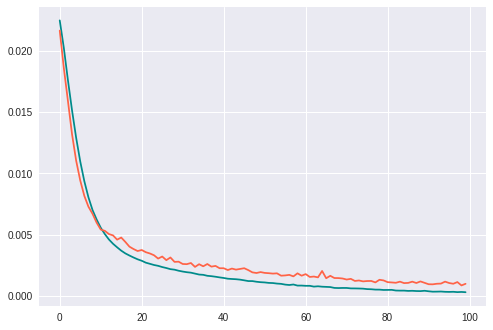

In [0]:
plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(test_losses, color="tomato",label="validation")
plt.show()

In [0]:
predictions=[]

for i, (image,label) in enumerate(test_loader):
    image=image.unsqueeze_(0)
    image=image.permute(1, 0, 2,3)
    
    if use_gpu:
        image=image.cuda()
        label=label.cuda()

    prediction=resnet(image)
    pred_classes=prediction.data.max(1,keepdim=True)[1]
    predictions.append(pred_classes)

In [0]:
results=[]
for i in predictions:
    for j in i:
        results.append(j.item())

In [0]:
df=pd.DataFrame(results,columns=['Category'])
file=df.to_csv()

In [0]:
from google.colab import files

with open('resnet.csv','w') as f:
    f.write(file)
    
files.download('resnet.csv')